### Revealing the determinants of gender inequality in urban cycling with large-scale data
- Content: Data analysis on the impact of street-level features on the gender-cycling-gap in New York City
- Sample: Streets in the city of New York (2 filters: N* cyclists + network largest component)
- Last modified on the 02/03/2022 by AB

In [1]:
#Import libraries and directories
from pathlib import Path
import shap
import os
import ast
import pandas as pd 
import numpy as np
import geopandas
import pickle
from scipy import stats
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm, ListedColormap, LinearSegmentedColormap
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from matplotlib.ticker import FormatStrFormatter
from adjustText import adjust_text
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
import statsmodels.api as sm
import statsmodels.stats.api as sms

In [2]:
#Set data visualisation options, including colors
%matplotlib inline
matplotlib.rcParams.update({'font.size': 18, 'font.style': 'normal', 'font.family':'Arial'})
plt.rc('font', family='Arial') 
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

colors = [(169/255, 230/255, 85/255), (116/255, 88/255, 209/255)]
my_cmap = LinearSegmentedColormap.from_list("Custom", colors, N=20)
my_col1=my_cmap(0.25)
my_col2=my_cmap(0.7)
my_col3=my_cmap(0.85)
my_col4=(0.949, 0.839, 0.467)
my_col5=(0.325, 0.529, 0.659)
my_col6=(0.141, 0.259, 0.42)
colors = [my_col4, my_col5]
my_cmap1 = LinearSegmentedColormap.from_list("Custom", colors, N=20)
matplotlib.cm.register_cmap("Custom", my_cmap1)
cpal_1 = sns.color_palette('Custom', n_colors=64)

colors = [my_col6, my_col4]
my_cmap2 = LinearSegmentedColormap.from_list("Custom2", colors, N=20)

In [3]:
#For plot, normalize feature val so that max=1 and min=0 so that the scale work for dummy and continuous variable
def translate(value, leftMin, leftMax, rightMin, rightMax):
    # Figure out how 'wide' each range is
    leftSpan = leftMax - leftMin
    rightSpan = rightMax - rightMin
    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - leftMin) / float(leftSpan)
    # Convert the 0-1 range into a value in the right range.
    return rightMin + (valueScaled * rightSpan)

label_dict={'3_Boro':'Queens',
 'bike_lane_unprotected':'Unprotected cycleway',
 'Betweenness_norm':'Edge betweenness',
 'bike_lane_protected':'Protected cycleway',
 'accidents_all_norm':'Any-vehicle crashes',
 'accidents_bikes_norm':'Bike crashes',
 '1_Boro':'Brooklyn',
 '2_Boro':'Bronx',
 'surface_classified':'Unpaved surface',
 'park':'Park proximity',
 'coastline':'Coast proximity',
 'lighting_classified':'Public lighting'}   


In [4]:
#Define directory
path = '../'
os.chdir(path)

### Analysis

In [5]:
# Upload final dataset
dataset=geopandas.read_file('/Users/Alice/Desktop/final data/final_newyork_ready_for_analysis.shp') 
#Keep only relevant features
dataset=dataset.drop(columns='geometry')
dataset.rename(columns={'bike_lan_1':'bike_lane_unprotected',
       'bike_lan_2':'bike_lane_protected',
       'surface_cl':'surface_classified',
       'lighting_c':'lighting_classified',  'accident_1': 'accidents_bikes_norm',
       'accident_4': 'accidents_all_norm',
       'Betweenn_1':'Betweenness_norm'}, inplace=True)

#Normalise accidents data and edge-betweenness between [0,1] 
scaler = StandardScaler() 
scaler.fit(dataset[['accidents_bikes_norm','accidents_all_norm', 'Betweenness_norm']])  
dataset[['accidents_bikes_norm','accidents_all_norm', 'Betweenness_norm']] = scaler.transform(dataset[['accidents_bikes_norm','accidents_all_norm', 'Betweenness_norm']])

#Define selected features
selected_features=[
       'bike_lane_unprotected', 'bike_lane_protected','lighting_classified', 'surface_classified',
       'accidents_bikes_norm',
       'accidents_all_norm',
       'coastline', 'park' , '1_Boro', '2_Boro',
       '3_Boro',  'Betweenness_norm']

dataset.head(5)

,ratio,bike_lane_unprotected,bike_lane_protected,lighting_classified,surface_classified,accidents_bikes_norm,accidents_all_norm,coastline,park,1_Boro,2_Boro,3_Boro,Betweenness_norm
0,0.129149,0,1,1,99,-0.413354,-0.463322,0,1,0.0,0.0,0.0,-0.193715
1,0.132459,0,1,1,99,-0.413354,-0.463322,0,1,0.0,0.0,0.0,-0.180954
2,0.128709,0,1,1,0,-0.413354,-0.463322,0,1,0.0,0.0,0.0,-0.180954
3,0.109093,0,1,1,0,-0.413354,-0.463322,0,1,0.0,0.0,0.0,-0.157223
4,0.118957,0,1,1,99,-0.413354,-0.463322,0,1,0.0,0.0,0.0,-0.206104


In [6]:
dataset.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 25763 entries, 0 to 25762
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ratio                  25763 non-null  float64
 1   bike_lane_unprotected  25763 non-null  int64  
 2   bike_lane_protected    25763 non-null  int64  
 3   lighting_classified    25763 non-null  int64  
 4   surface_classified     25763 non-null  int64  
 5   accidents_bikes_norm   25763 non-null  float64
 6   accidents_all_norm     25763 non-null  float64
 7   coastline              25763 non-null  int64  
 8   park                   25763 non-null  int64  
 9   1_Boro                 25763 non-null  float64
 10  2_Boro                 25763 non-null  float64
 11  3_Boro                 25763 non-null  float64
 12  Betweenness_norm       25763 non-null  float64
dtypes: float64(7), int64(6)
memory usage: 2.6 MB


- Run multivariate logistic regression for three different values of the threshold \alpha=[0.25, 0.33, 0.40]

In [7]:
# Logisitc Regression
def store_res(model_fit):
    p = model_fit.params
    p_val=model_fit.pvalues
    ci95_l=model_fit.conf_int()[0]
    ci95_u=model_fit.conf_int()[1]
    results_table = pd.DataFrame([p, p_val, ci95_l, ci95_u]).T.rename(columns={'Unnamed 0': "parameters",  'Unnamed 1': 'p values', 0: 'ci95_lower', 1: 'ci95_upper'})

    results_table['significance']=results_table.apply(lambda x: 1 if  x['p values']<0.05 else 0 , axis=1)       
    results_table=results_table.sort_values(by='parameters').reset_index(drop=False)
    results_table['ind']=results_table.index
    results_table['label']=results_table['index'].apply(lambda x: label_dict[x])
    return results_table

# Use statsmodel sm instead of 
#Filter dataset to include only streets belonging to the top and bottom 33% of the distribution
results={}
observations={}
accuracies={}
for i in [25, 33, 40]:
    dataset_two=dataset.copy()
    threshold1=np.percentile(dataset_two.ratio, i)
    threshold2=np.percentile(dataset_two.ratio, 100-i)
    dataset_two['ratio_2classified']=dataset_two.apply(lambda x: 0 if x['ratio']<=threshold1 else np.nan, axis=1)
    dataset_two['ratio_2classified']=dataset_two.apply(lambda x: 1 if x['ratio']>=threshold2 else x['ratio_2classified'], axis=1)
    dataset_two=dataset_two[dataset_two['ratio_2classified'].isnull()==False]
    X = dataset_two[selected_features]
    #dependent variable
    y = dataset_two['ratio_2classified']
    #Split= 20% for validation and 80% for training
    #X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.20, random_state=0) 
    log_reg = sm.Logit(y, X).fit()
    print(log_reg.summary())
    observations[i]=log_reg.nobs

    # performing predictions on the test datdaset
    yhat = log_reg.predict(X)
    prediction = list(map(round, yhat))

    # confusion matrix
    cm = confusion_matrix(y, prediction)
    print ("Confusion Matrix : \n", cm)
    # accuracy score of the model
    print('Test accuracy = ', accuracy_score(y, prediction))
    accuracies[i]=accuracy_score(y, prediction)
    #Store results in table
    results[i]=store_res(log_reg)

Optimization terminated successfully.
         Current function value: 0.596768
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:      ratio_2classified   No. Observations:                12893
Model:                          Logit   Df Residuals:                    12881
Method:                           MLE   Df Model:                           11
Date:                Wed, 02 Mar 2022   Pseudo R-squ.:                  0.1390
Time:                        12:46:44   Log-Likelihood:                -7694.1
converged:                       True   LL-Null:                       -8936.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
bike_lane_unprotected     1.4140      0.046     30.607      0.000       1.323       1.

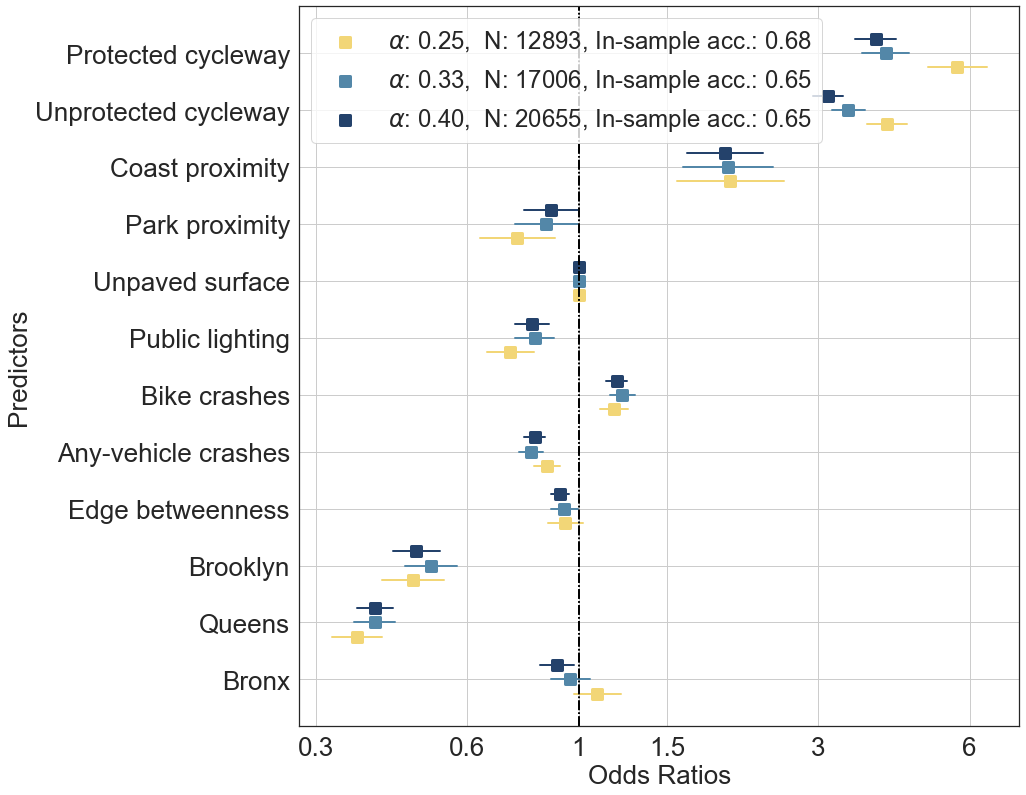

In [8]:
col=[my_col4, my_col5, my_col6]
pos_dict={'Queens':1,
 'Unprotected cycleway': 10,
 'Edge betweenness': 3,
 'Protected cycleway': 11,
 'Any-vehicle crashes' : 4,
 'Bike crashes': 5,
 'Brooklyn': 2,
 'Bronx':0,
 'Unpaved surface': 7,
 'Park proximity':8,
 'Coast proximity':9,
 'Public lighting': 6} 
alphas=[1,1,1]

fig=plt.figure(figsize=(10,10))  
ax=fig.add_axes([0, 1, 1, 1])
for en,i in enumerate([25, 33, 40]):
    results_table=results[i].copy()
    results_table['ind']=results_table.label.apply(lambda x: pos_dict[x])
    results_table['ind2']=results_table['ind']+[0.25*(en-1)]*len(results_table)
    for ind in list(results_table.ind):
        ax.plot([np.exp(results_table[results_table.ind==ind].ci95_lower),np.exp(results_table[results_table.ind==ind].ci95_upper)], [ind+0.25*(en-1),ind+0.25*(en-1)], color=col[en], alpha=alphas[en], linewidth=2)      
    ax.scatter(np.exp(results_table.parameters.to_list()), results_table.ind2.to_list(),marker='s', s=90,color=col[en],edgecolor=col[en], alpha=alphas[en], linewidth=3, label=r'$\alpha$: %0.2f,  N: %.0f, In-sample acc.: %0.2f' %((i/100), observations[i], accuracies[i]))
    ax.set_yticks(range(0, len(results_table.ind.to_list()), 1))
    ax.set_yticklabels(results_table.sort_values(by='ind').label.to_list())
    ax.set_ylabel('Predictors', fontsize=26)
    ax.set_xlabel('Odds Ratios', fontsize=26)
    ax.axvline(1, color='black', linestyle='-.', )
    ax.set_xscale('log')
    ax.set_xticks([0.3, 0.6,  1, 1.5, 3, 6])
    ax.set_xticklabels([0.3, 0.6,  1, 1.5, 3,6])
    legend=ax.legend(facecolor='white', fontsize=24, loc='upper left')
    plt.grid(visible=True, which='major', axis='both')
    ax.tick_params(axis='both', which='major', labelsize=26)

- Try improving (out-of-sample) accuracy using a ML + ShAP procedure. Notice that for the logisitc regression we obtain similar out of sample and in-sample accuracy
- hyperpar_search_best_dict store the results of a grid-search optimization algorithm to identify best parameters setting

In [9]:
#Load dictionaries with stored info on Hyperparameters maximization for each model
hyperPar_search_best_dict_LR=pickle.load(open('IntermediateDataStorage/BestTunedHyperParam_analysis_LR_bin.p', "rb" ) )
hyperPar_search_best_dict_RF=pickle.load(open('IntermediateDataStorage/BestTunedHyperParam_analysis_RF_bin.p', "rb" ) )

#Filter dataset to include only streets belonging to the top and bottom 33% of the distribution
dataset_two=dataset.copy()
alpha=33
threshold1=np.percentile(dataset_two.ratio, alpha)
threshold2=np.percentile(dataset_two.ratio, 100-alpha)
dataset_two['ratio_2classified']=dataset_two.apply(lambda x: 0 if x['ratio']<=threshold1 else np.nan, axis=1)
dataset_two['ratio_2classified']=dataset_two.apply(lambda x: 1 if x['ratio']>=threshold2 else x['ratio_2classified'], axis=1)
dataset_two=dataset_two[dataset_two['ratio_2classified'].isnull()==False]

X = dataset_two[selected_features]
#dependent variable
y = dataset_two['ratio_2classified']
#Split= 20% for validation and 80% for training
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.20, random_state=0) 

models = []
models.append(('Dummy Classifier', DummyClassifier(strategy='stratified', random_state=0)))
models.append(('Logistic Regression', LogisticRegression(penalty='none', max_iter=10000, fit_intercept=False)))
models.append(('Random Forest', RandomForestClassifier(max_features=hyperPar_search_best_dict_RF['max_features'], min_samples_leaf=hyperPar_search_best_dict_RF['min_samples_leaf'], min_samples_split=hyperPar_search_best_dict_RF['min_samples_split'], n_estimators=hyperPar_search_best_dict_RF['n_estimators'])))

# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

Dummy Classifier: 0.498090 (0.007364)
Logistic Regression: 0.655249 (0.014966)
Random Forest: 0.816304 (0.010350)


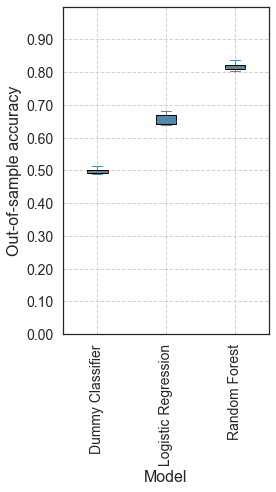

In [10]:
# Compare Algorithms
fig=plt.figure(figsize=(4,7))
ax=plt.subplot(1,1,1)
ax.boxplot(results,patch_artist=True,
            boxprops=dict(facecolor=my_col5),
            capprops=dict(color=my_col5),
            whiskerprops=dict(color=my_col5),
            flierprops=dict(color=my_col5, markeredgecolor=my_col5),
            medianprops=dict(color='grey'))
ax.set_ylabel('Out-of-sample accuracy', size=16)
ax.set_xlabel('Model', size=16)
ax.set_xticks(np.arange(3)+1)
ax.set_ylim([0, 1])
ax.set_xticklabels(names, size=14 , rotation=90, ha='center')
ax.set_yticks(np.arange(0,1, 0.1))
ax.set_yticklabels((np.arange(0,1, 0.1)), size=14)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.grid(b=True, which='major', axis='both', color='lightgrey', linestyle='--', linewidth=1)
plt.tight_layout()

 - Use Random Forest + ShAP for comparison with the results obtained using the multivariate logistic regression.
 - hyperPar_search_best_dict_RF store the results of a grid-search optimization algoritm to identify best parameters setting

In [11]:
# Random forest + ShAP
rf = RandomForestClassifier(max_features=hyperPar_search_best_dict_RF['max_features'], min_samples_leaf=hyperPar_search_best_dict_RF['min_samples_leaf'], min_samples_split=hyperPar_search_best_dict_RF['min_samples_split'], n_estimators=hyperPar_search_best_dict_RF['n_estimators']).fit(X_train, Y_train)
predictions = rf.predict(X_validation)
# Evaluate predictions
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.8371546149323927
[[1410  284]
 [ 270 1438]]
              precision    recall  f1-score   support

         0.0       0.84      0.83      0.84      1694
         1.0       0.84      0.84      0.84      1708

    accuracy                           0.84      3402
   macro avg       0.84      0.84      0.84      3402
weighted avg       0.84      0.84      0.84      3402



In [ ]:
#Export random selection of records for ShAP values
import random
random.seed(0)
randomlist = []
for i in range(0,1000):
    n = random. randint(0,1000) 
    randomlist.append(n)


explainer = shap.TreeExplainer(rf)
ForShaP=X_validation.reset_index(drop=True).copy()
ForShaP=ForShaP[ForShaP.index.isin(randomlist)]
shap_values = explainer.shap_values(ForShaP)
#np.savetxt('IntermediateDataStorageResults/NY_binary_label_entire_sample_shapvalues_0_1000_random.csv', shap_values[0])

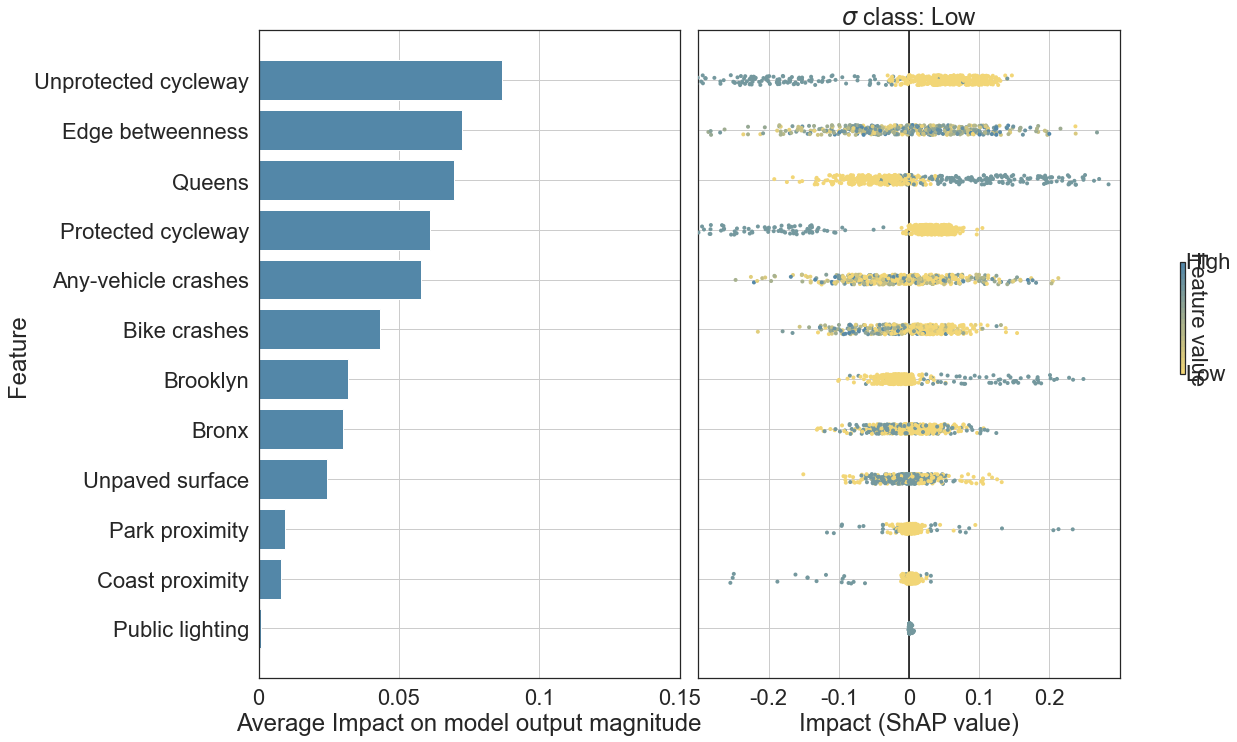

In [14]:
#Plot shap values using swarmplot for the three categories
import matplotlib.cm as cm

for i in range(12):
    ForShaP[ForShaP.columns[i]]=ForShaP[ForShaP.columns[i]].apply(lambda x: translate(x,ForShaP[ForShaP.columns[i]].min() , ForShaP[ForShaP.columns[i]].max(), 0, 1))  

pos=[[0, 0, 0.45 ,0.9],
    [0.47, 0, 0.45 ,0.9],
    [0.95, 0.2, 0.04 ,0.6]]
fig=plt.figure(figsize=(13,10))

vals={}
for i in [0 ,1]:
    vals[i] = np.abs(shap_values[i]).mean(0)
feature_names = ForShaP.columns
feature_importance = pd.DataFrame(list(zip(feature_names, vals[0],vals[1] )),
                                      columns=['col_name','feature_importance_low',  'feature_importance_high'])
feature_importance['sum_importance']=feature_importance[['feature_importance_low', 'feature_importance_high']].sum(axis=1)
feature_importance.sort_values(by=['sum_importance'],
                                   ascending=True, inplace=True)
feature_importance=feature_importance.reset_index(drop=True)
feature_importance['label']=feature_importance.apply(lambda x: label_dict[x['col_name']], axis=1)
ax=fig.add_axes(pos[0])
ax.barh(feature_importance.index.tolist(), feature_importance.feature_importance_high, color=my_col5, label='High')
ax.set_yticks(feature_importance.index.tolist())
ax.set_yticklabels(feature_importance.label, fontsize=22)
ax.set_xlabel('Average Impact on model output magnitude', fontsize=24)
ax.set_ylabel('Feature', fontsize=24)
ax.set_xticks(np.linspace(0, 0.25, 6))
ax.set_xticklabels([0, 0.05, 0.1, 0.15, 0.2, 0.25], fontsize=22)
ax.set_ylim([-1, 12])
ax.set_xlim([0, 0.15])
ax.grid(which='major', axis='both')
cat=0
cat_name='Low'
n=500 #Number of points to plot
val=[]
var=[]
original_val=[]
for ind,i in enumerate(ForShaP.columns):
    original_val.extend(ForShaP[i][0:n])
    val.extend(shap_values[cat][0:n,ind].tolist())
    var.extend([i]*n)

df=pd.DataFrame({'impact':val,'variable':var, 'feature_val':original_val})
df=pd.merge(df, feature_importance.reset_index(drop=False)[['index', 'col_name']], right_on='col_name', left_on='variable')
df=df.sort_values(by='index', ascending=True)
ax=fig.add_axes(pos[1])
sns.stripplot(x='impact', y='variable', hue='feature_val',edgecolor='black',palette=cpal_1, size=4,data=df, ax=ax, vmin=0, vmax=1.1)
ax.set_title(r'$\sigma$ class: '+cat_name, fontsize=24)
ax.axvline(0, color='black')
ax.grid(which='major', axis='both')
plt.setp(ax.get_yticklabels(), visible=False)
ax.set_ylabel('')
ax.set_xlim([-0.3, 0.3])
ax.set_ylim([-1, 12])
ax.set_xticks(np.linspace(-0.2, 0.2, 5))
ax.set_xticklabels([-0.2, -0.1, 0, 0.1, 0.2], fontsize=22)
ax.set_xlabel('Impact (ShAP value)', fontsize=24)
ax.legend([],[], frameon=False)

ax=fig.add_axes(pos[2])
ax.axis('off')
cbar = fig.colorbar(cm.ScalarMappable(cmap='Custom'))
cbar.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(['Low', 'High']):
    cbar.ax.text(1, j, lab, ha='left', va='center', size=22)
cbar.ax.get_yaxis().labelpad = 22
cbar.ax.set_ylabel('Feature value', rotation=270, size=22)